# TP2:M√©thodes bas√©es sur la th√©orie des valeurs extr√™mes

Ce TP est une continuit√© du TP-1 dans lequel on souhaitait impl√©menter
la VaR (Value at Risk) et l‚ÄôES (Expected Shortfall) en utilisant les
m√©thodes classiques propos√©es dans la r√©glementation b√¢loise, i.e.¬†la
m√©thode historique, param√©trique et bootstrap. Cependant, une limite de
ces m√©thodes est qu‚Äôelles ne prennent pas en compte la queue de
distribution de la perte. Pour rem√©dier √† cela, on peut utiliser des
m√©thodes avec la th√©orie des valeurs extr√™mes, i.e.¬†l‚Äôapproche Block
Maxima et l‚Äôapproche Peaks Over Threshold.

In [1]:
# D√©finition des librairies
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


In [2]:
# Import des donn√©es du CAC 40
data = yf.download("^FCHI")

# Calcul des rendements logarithmiques
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

# Retirer la premi√®re ligne
data = data.dropna()

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

In [3]:
train = data[['log_return',"Close"]]['15-10-2008':'26-07-2022']
data_train = train['log_return']
neg_data_train = -data_train

test = data[['log_return',"Close"]]['27-07-2022':'11-06-2024']
data_test = test['log_return']
neg_data_test = -data_test

## I. Impl√©mentation de la VaR avec la th√©orie des valeurs extr√™mes

### I.1. VaR TVE : Approche Maxima par bloc

L‚Äôapproche des Block Maxima (BM) est une m√©thode mod√©lise les maxima des
rendements sur des blocs de taille fixe $s$ en utilisant la distribution
GEV. Le seuil de confiance $\alpha_{\text{GEV}}$ est ajust√© pour
correspondre √† l‚Äôhorizon temporel de la VaR via la relation :

$$
\frac{1}{1-\alpha_{\text{VaR}}} = s \times \frac{1}{1-\alpha_{\text{GEV}}}.
$$

Nous allons dans ce projet une taille de blocs $s = 21$ jours ouvr√©s
comme ce qui souvent utilis√© en pratique. De ce fait, nous parvenons √†
construire 239 blocs de taille 21 et un bloc de taille De fait, la
Value-at-Risk sur un horizon 1 et pour un niveau de confiance \$ \_{}\$
est :

$$
\text{VaR}_h(\alpha_{\text{VaR}}) = G^{-1}_{(\hat \mu, \hat \sigma, \hat \xi)}(\alpha_{\text{GEV}}),
$$

o√π G est la fonction de r√©partition de la GEV
($\hat \mu, \hat \sigma, \hat \xi$) estim√©e.

### I.1.1. Construction de l‚Äô√©chantillon de maxima sur data_train

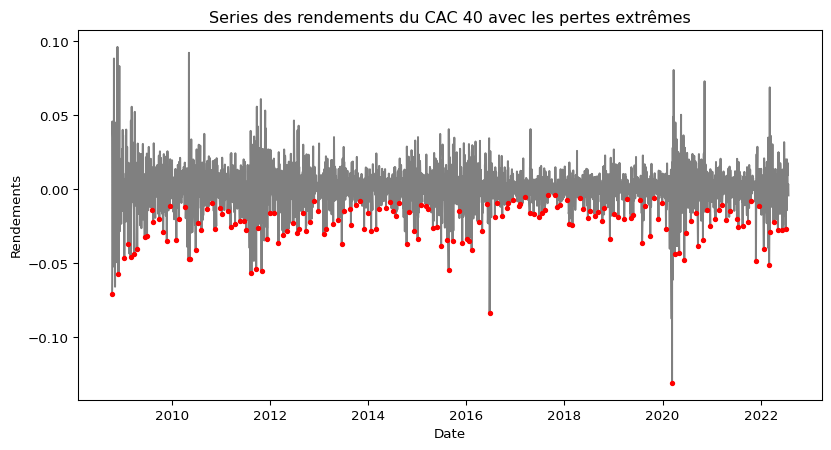

In [4]:
import numpy as np
import pandas as pd

def get_extremes(returns, block_size, min_last_block=0.6):
    """
    Extrait les valeurs extr√™mes d'une s√©rie de rendements par blocs.
    
    Arguments :
    returns : pandas Series (index = dates, valeurs = rendements)
    block_size : int, taille du bloc en nombre de jours
    min_last_block : float, proportion minimale pour inclure le dernier bloc incomplet
    
    Retourne :
    maxima_sample : liste des valeurs maximales par bloc
    maxima_dates : liste des dates associ√©es aux valeurs maximales
    """
    n = len(returns)
    num_blocks = n // block_size

    maxima_sample = []
    maxima_dates = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = (i + 1) * block_size
        block_data = returns.iloc[block_start:block_end]  # S√©lectionner le bloc avec les index

        max_value = block_data.max()
        max_date = block_data.idxmax()  # R√©cup√©rer l'index de la valeur max

        maxima_sample.append(max_value)
        maxima_dates.append(max_date)

    # Gestion du dernier bloc s'il reste des donn√©es suffisantes
    block_start = num_blocks * block_size
    block_data = returns.iloc[block_start:]

    if len(block_data) >= min_last_block * block_size:
        max_value = block_data.max()
        max_date = block_data.idxmax()
        
        maxima_sample.append(max_value)
        maxima_dates.append(max_date)
        
    return pd.Series(maxima_sample, index=maxima_dates)  # Retourner une Series avec les dates comme index


extremes = get_extremes(neg_data_train, block_size=21, min_last_block=0.6)

plt.figure(figsize=(10, 5))
plt.plot(data_train, color="grey")
plt.plot(-extremes,".", color="red") # 
plt.title("Series des rendements du CAC 40 avec les pertes extr√™mes")
plt.xlabel("Date")
plt.ylabel("Rendements")
plt.show()

Pour avoir une id√©e de la distribution GEV de la serie des pertes
maximales de rendements du CAC 40 pour $s=21$, nous utilisons un Gumbel
plot qui est un outil graphique pour juger de l‚Äôhypoth√®se $\xi=0$,
i.e.¬†la distribution GEV se r√©duit √† la distribution de Gumbel.

Pour le construire, nous devons suivre les √©tapes suivantes :

1.  calculer l‚Äôabscisse avec la s√©rie des maximas ordon√©es
    $R_{(1)} \leq R_{(2)} \leq \ldots \leq R_{(n)}$.
2.  calculer l‚Äôordonn√©e de la mani√®re suivante :

$$
- log(-log(\frac{i - 0.5}{k})), \quad i = 1, \ldots, k.
$$

Lorsque la distribution adapt√©e est celle de Gumbel alors le Gumbel plot
est lin√©aire. Dans notre cas, nous constatons une courbure ce qui nous
pousse √† conclure qu‚Äôune distribution Gumbel n‚Äôest pas adapt√©e dans la
mod√©lisation des maxima des pertes de rendements du CAC 40. Une
distribution Fr√©chet ou de Weibull serait plus adapt√©e.

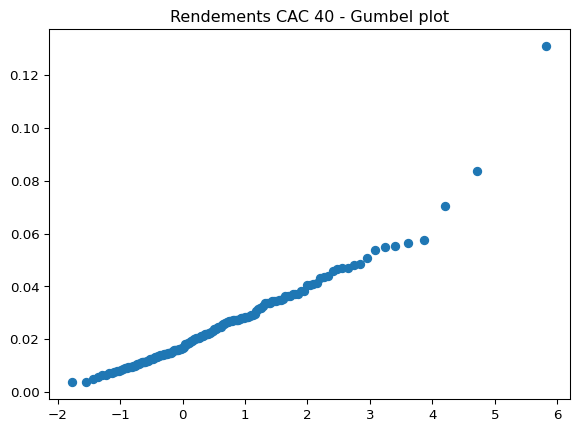

In [5]:
quantiles_theoriques_gumbel = []
k=len(extremes)
for i in range(1,len(extremes)+1):
    val = -np.log(-np.log((i-0.5)/k))
    quantiles_theoriques_gumbel.append(val)

# Tracer le Gumbel plot
plt.scatter(quantiles_theoriques_gumbel, np.sort(extremes), marker='o')
plt.title('Rendements CAC 40 - Gumbel plot')
plt.show()

### I.1.2. Estimation des param√®tres de la loi de GEV

En estimant les param√®tres de la loi GEV, nous utilisons la m√©thode du
maximum de vraisemblance. Les param√®tres estim√©s par maximisation de la
fonction de vraisemblance sont les suivants
$\xi = -0.15, \mu=0.02, \sigma=0.01$. Nous constatons par ailleurs que
le param√®tre de forme $\xi$ est n√©gatif ce qui est coh√©rent avec notre
observation pr√©c√©dente.

In [6]:
from scipy.stats import genextreme as gev

params_gev = gev.fit(extremes)

shape, loc, scale = params_gev
# Afficher les param√®tres estim√©s
print("="*50)
print("Param√®tres estim√©s de la distribution GEV")
print("="*50)
print(f"Shape (xi) = {shape:.2f}")
print(f"Loc (mu) =  {loc:.2f}")
print(f"Scale (sigma) = {scale:.2f}")
print("="*50)

Param√®tres estim√©s de la distribution GEV
Shape (xi) = -0.15
Loc (mu) =  0.02
Scale (sigma) = 0.01

Pour accorder plus de poids √† cette observation, nous avons calcul√© un
intervalle de confiance profil√© √† 95% pour le param√®tre de forme $\xi$.
Pour ce faire, nous avons suivi les √©tapes suivantes : 1. Estimation des
param√®tres par maximum de vraisemblance : Nous avons estim√© $\hat{\xi}$,
$\hat{\mu}$ et $\hat{\sigma}$ en maximisant la log-vraisemblance de la
loi GEV.

1.  Construction du profil de vraisemblance : Nous avons fix√© $\xi$ √†
    diff√©rentes valeurs autour de $\hat{\xi}$ et, pour chacune, r√©estim√©
    $\mu$ et $\sigma$ afin d‚Äôobtenir une log-vraisemblance profil√©e.

2.  Seuil bas√© sur le test du rapport de vraisemblance : Le seuil
    critique est d√©termin√© par la statistique \$ ^2(1) \$ :  
    $$
     \mathcal{L}_{\max} - \frac{\chi^2_{0.95, 1}}{2}
     $$

3.  D√©termination des bornes de l‚ÄôIC : L‚Äôintervalle est form√© par les
    valeurs de $\xi$ pour lesquelles la log-vraisemblance reste
    au-dessus de ce seuil.

Cette approche permet une meilleure prise en compte de l‚Äôincertitude en
√©vitant les approximations asymptotiques classiques. La mod√©lisation des
maxima des pertes de rendements du CAC 40 par une distribution de
Weibull serait plus adapt√©e.

Nous obtenons ainsi un intervalle de confiance √† 95% pour le param√®tre
de forme $\xi$ de $[-0.284, -0.039]$. Comme 0 n‚Äôappartient pas √† cet
intervalle, nous pouvons rejeter l‚Äôhypoth√®se $\xi=0$. De ce fait, la
distribution de Weibull est plus adapt√©e pour mod√©liser les maxima des
pertes de rendements du CAC 40 car $\xi$ est n√©gatif.

IC profil√© pour shape: [-0.287, -0.042]

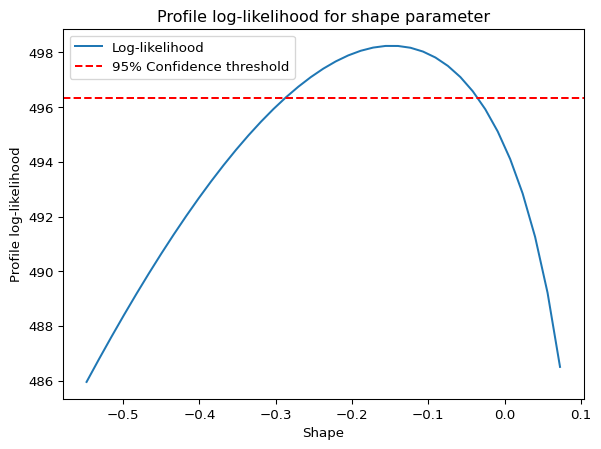

In [7]:
from scipy.optimize import minimize
from scipy.stats import chi2

# Fonction de log-vraisemblance
def gev_neg_log_likelihood(params, shape_fixed, data):
    """
    Calcule la log-vraisemblance n√©gative de la distribution GEV
    en fixant le param√®tre 'shape'.
    """
    loc, scale = params
    if scale <= 0:  # Contrainte pour √©viter des valeurs invalides
        return np.inf
    return -np.sum(gev.logpdf(data, shape_fixed, loc=loc, scale=scale))

# Log-vraisemblance maximale
log_likelihood_max = -gev_neg_log_likelihood([loc, scale], shape, extremes)

# Calcul des IC profil√©s pour le param√®tre shape
shape_grid = np.linspace(shape - 0.4, shape + 0.4, 50)  # Plage autour de la valeur estim√©e
profile_likelihood = []

for s in shape_grid:
    # R√©optimiser loc et scale en fixant shape
    result = minimize(
        gev_neg_log_likelihood,
        x0=[loc, scale],  # Initial guess for loc and scale
        args=(s, extremes),  # Fixer 'shape' √† la valeur actuelle
        bounds=[(None, None), (1e-5, None)],  # Contraintes sur loc et scale
        method='L-BFGS-B'
    )
    if result.success:
        profile_likelihood.append(-result.fun)
    else:
        profile_likelihood.append(np.nan)

# Calcul du seuil pour les IC
chi2_threshold = log_likelihood_max - chi2.ppf(0.95, 1) / 2

# D√©terminer les bornes des IC
profile_likelihood = np.array(profile_likelihood)
valid_points = np.where(profile_likelihood >= chi2_threshold)[0]
if len(valid_points) > 0:
    lower_bound = shape_grid[valid_points[0]]
    upper_bound = shape_grid[valid_points[-1]]
    print(f"IC profil√© pour shape: [{lower_bound:.3f}, {upper_bound:.3f}]")
else:
    print("Impossible de d√©terminer des IC profil√©s avec les param√®tres actuels.")

# Trac√© du profil de log-vraisemblance
plt.plot(shape_grid, profile_likelihood, label="Log-likelihood")
plt.axhline(chi2_threshold, color='red', linestyle='--', label="95% Confidence threshold")
plt.xlabel("Shape")
plt.ylabel("Profile log-likelihood")
plt.title("Profile log-likelihood for shape parameter")
plt.legend()
plt.show()

#### a. Validation ex-ante

On remarque la loi GEV estim√©e par une weibull semble coller √† la
distribution des rendements extr√™mes du CAC 40. De plus, en utilisant un
QQ-plot, nous constatons que les quantiles th√©oriques de la GEV-Weibull
et empiriques sembelnt align√©s sauf pour les quantiles √©l√©v√©s o√π l‚Äôon
constate un d√©crochage.

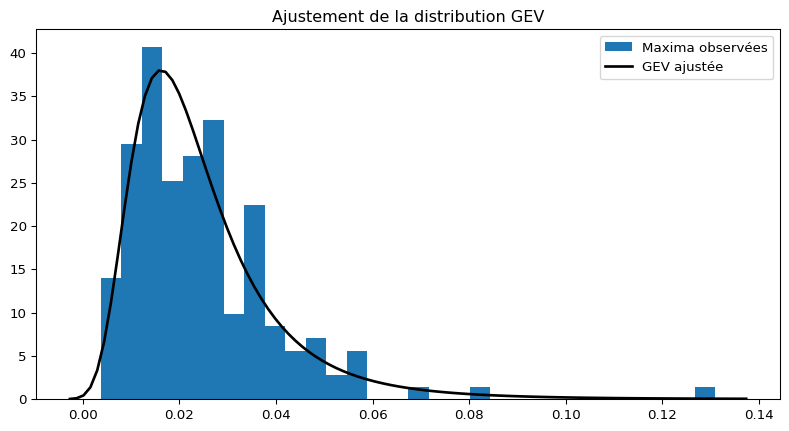

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=30, density=True, label='Maxima observ√©es')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_gev = gev.pdf(x, *params_gev)
plt.plot(x, p_gev, 'k', linewidth=2, label='GEV ajust√©e')
plt.title("Ajustement de la distribution GEV")
plt.legend()
plt.show()

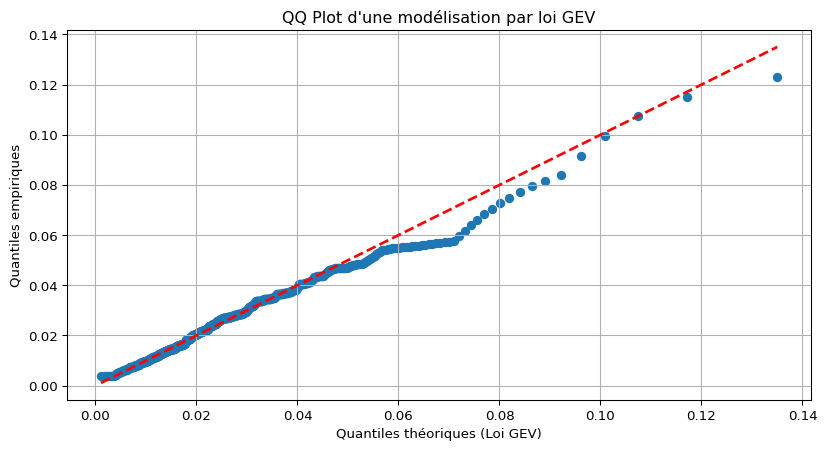

In [9]:
niveaux_quantiles = np.arange(0.001,1, 0.001)
quantiles_empiriques_TVE = np.quantile(extremes, niveaux_quantiles) 
quantiles_theoriques_GEV = gev.ppf(niveaux_quantiles, shape, loc = loc, scale = scale)

plt.figure(figsize=(10, 5))
plt.scatter(quantiles_theoriques_GEV, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_GEV, quantiles_theoriques_GEV, color='red', linestyle='dashed', linewidth=2, label='Premi√®re bissectrice')
plt.title("QQ Plot d'une mod√©lisation par loi GEV")
plt.xlabel('Quantiles th√©oriques (Loi GEV)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

#### b. Calcul de la VaR TVE par MB

Pour calculer la VaR TVE pour un horizon de 1jour par MB, nous utilisons
la formule suivante :

$$
\text{VaR}_h(\alpha_{\text{VaR}}) = G^{-1}_{(\hat \mu, \hat \sigma, \hat \xi)}(\alpha_{\text{GEV}}),
$$

o√π G est la fonction de r√©partition de la
GEV$(\hat \mu, \hat \sigma, \hat \xi)$ estim√©e, et $\alpha_{\text{GEV}}$
est ajust√© pour correspondre √† l‚Äôhorizon temporel de la VaR via la
relation :

$$
\frac{1}{1-\alpha_{\text{VaR}}} = s \times \frac{1}{1-\alpha_{\text{GEV}}}.
$$

Pour convertir la VaR √† horizon 1jour en VaR √† horizon T jours, la
m√©thode de scaling soul√®ve quelques questions, car elle repose
essentiellement sur la normalit√© et l‚Äôind√©pendance des rendements ce qui
n‚Äôest pas le cas en pratique. De ce fait, nous utiliserons la m√©thode
alternative reposant sur la th√©orie des valeurs extr√™mes.

y revenir

In [10]:
def BM_var(alpha,s,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    alpha_bm = 1-s*(1-alpha)

    return gev.ppf(alpha_bm, shape, loc = loc, scale = scale),alpha_bm

alpha = 0.99
var_BM_train,alpha_bm = BM_var(0.99, 21, shape, loc, scale)

print(f"La VaR TVE pour h=1j et alpha={alpha} est : {var_BM_train:.4%}")
print(f"La VaR TVE pour h=10j et alpha={alpha} est : {(10**alpha_bm)*var_BM_train:.4%}")

La VaR TVE pour h=1j et alpha=0.99 est : 3.3274%
La VaR TVE pour h=10j et alpha=0.99 est : 20.5167%

### I.1.3. Estimation des param√®tres de la loi de EV

Bien que l‚Äôintervalle de confiance √† 95% pour le param√®tre de forme
$\xi$ de $[-0.284, -0.039]$ ne contienne pas 0, nous avons tout de m√™me
estim√© les param√®tres de la loi EV pour comparer les r√©sultats avec ceux
de la loi GEV. En estimant tout de m√™me les param√®tres de la loi EV,
nous obtenons les param√®tres suivants : $\mu=0.02, \sigma=0.01, \xi=0$.

Nous constatons que la loi EV ne semble pas mal s‚Äôadapter √† la
distribution des rendements extr√™mes du CAC 40.

In [11]:
from scipy.stats import gumbel_r

params_gumbel = gumbel_r.fit(extremes)

# Afficher les param√®tres estim√©s
print("="*50)
print("Param√®tres estim√©s de la distribution GEV GUMBEL")
print("="*50)
print(f"Loc (mu) =  {params_gumbel[0]:.2f}")
print(f"Scale (sigma) = {params_gumbel[1]:.2f}")
print("="*50)

Param√®tres estim√©s de la distribution GEV GUMBEL
Loc (mu) =  0.02
Scale (sigma) = 0.01

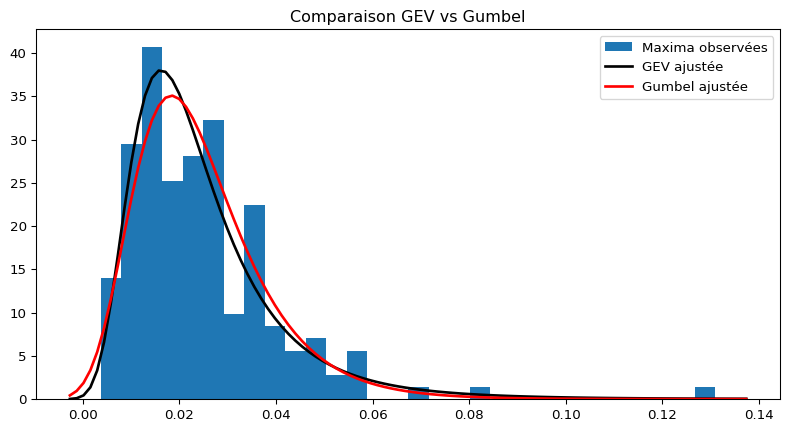

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=30, density=True, label='Maxima observ√©es')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densit√© GEV ajust√©e
p_gev = gev.pdf(x, *params_gev)
plt.plot(x, p_gev, 'k', linewidth=2, label='GEV ajust√©e')

# Densit√© Gumbel ajust√©e
p_gumbel = gumbel_r.pdf(x, *params_gumbel)
plt.plot(x, p_gumbel, 'r', linewidth=2, label='Gumbel ajust√©e')
title = "Comparaison GEV vs Gumbel"
plt.title(title)
plt.legend()
plt.show()

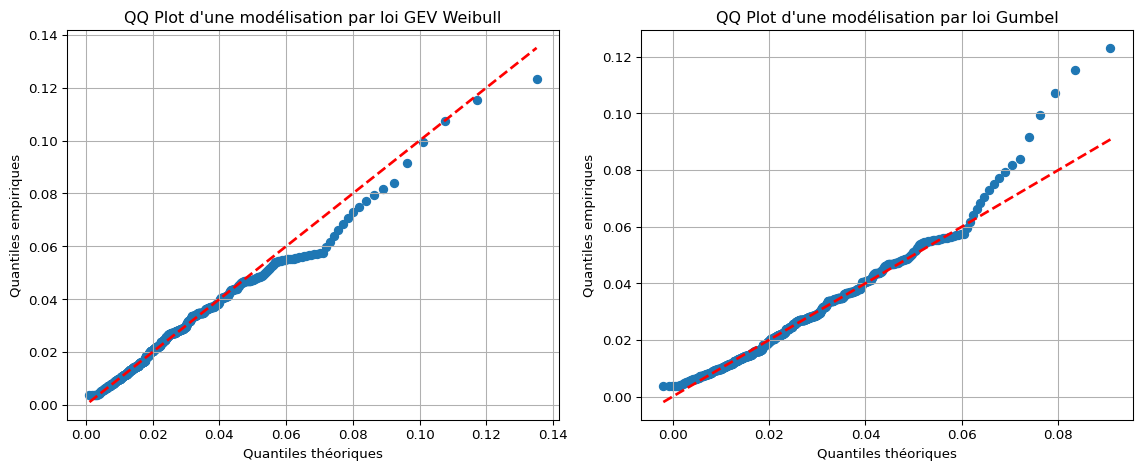

In [13]:
quantiles_theoriques_Gumb = gumbel_r.ppf(niveaux_quantiles, *params_gumbel)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(quantiles_theoriques_GEV, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_GEV, quantiles_theoriques_GEV, color='red', linestyle='dashed', linewidth=2, label='Premi√®re bissectrice')
plt.title("QQ Plot d'une mod√©lisation par loi GEV Weibull")
plt.xlabel('Quantiles th√©oriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(quantiles_theoriques_Gumb, quantiles_empiriques_TVE)
plt.plot(quantiles_theoriques_Gumb, quantiles_theoriques_Gumb, color='red', linestyle='dashed', linewidth=2, label='Premi√®re bissectrice')
plt.title("QQ Plot d'une mod√©lisation par loi Gumbel")
plt.xlabel('Quantiles th√©oriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
alpha = 0.99
var_BM_train,alpha_bm = BM_var(0.99, 21, shape=0, loc=params_gumbel[0], scale=params_gumbel[1])

print(f"La VaR TVE Gumbel pour h=1j et alpha={alpha} est : {var_BM_train:.4%}")
print(f"La VaR TVE Gumbel pour h=10j et alpha={alpha} est : {(10**alpha_bm)*var_BM_train:.4%}")

La VaR TVE Gumbel pour h=1j et alpha=0.99 est : 3.3513%
La VaR TVE Gumbel pour h=10j et alpha=0.99 est : 20.6638%

De plus, les r√©sultats en terme de VaR sont tr√®s proches entre les deux
mod√®les.

## I.2. VaR TVE : Approche Peak over threshold

### I.2.1. Choix du seuil u

Cette m√©thode est bas√©e sur la mod√©lisation de la distribution des exc√®s
au-dessus d‚Äôun seuil √©lev√© de log-rendement n√©gatif ($u$), seuil
d√©termin√© de mani√®re subjective √† partir de l‚Äôanalyse du mean residual
life plot, en ajustant une distribution de Pareto g√©n√©ralis√©e (GPD).
Dans le mean residual life plot, si les exc√®s au-del√† de ùíñ suivent une
loi GPD, alors le mean-excess plot a un comportement lin√©aire. On
cherche alors la valeur du seuil \$\$ pour laquelle le mean-excess plot
est lin√©aire. Nous ne privil√©gions pas les seuils $u$ √©lev√©s puisque la
moyenne est faite sur peu d‚Äôobservations.

Nous allons choisir un seuil $u = 0.03$ pour lequel le mean residual
life plot est lin√©aire. Nous allons ensuite ajuster une distribution GPD
pour les exc√®s au-dessus de ce seuil.

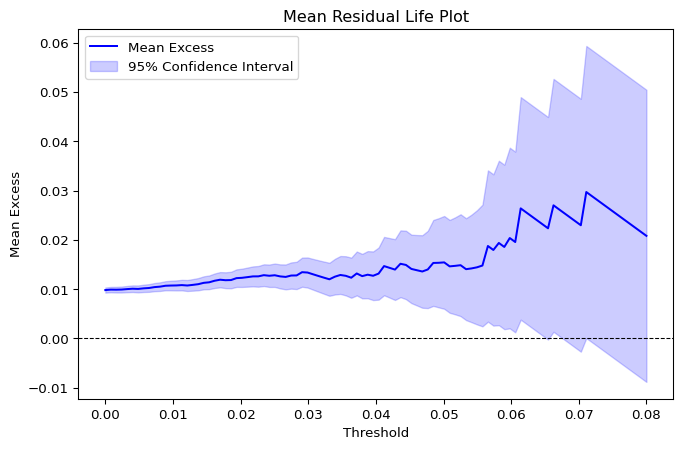

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, genpareto

def mean_residual_life_plot(data, tlim=None, pscale=False, nt=100, conf=0.95, return_values=False):
    """
    Trace le Mean Residual Life (MRL) Plot pour identifier un seuil optimal pour une GPD.

    Param√®tres :
    - data : array-like, donn√©es d'entr√©e.
    - tlim : tuple (min, max), limites des seuils (si None, calcul√© automatiquement).
    - pscale : bool, si True, utilise des quantiles au lieu de valeurs absolues.
    - nt : int, nombre de seuils √† consid√©rer.
    - conf : float, niveau de confiance pour l'intervalle (ex: 0.95 pour 95%).

    Retourne :
    - Un graphique MRL avec l'intervalle de confiance.
    """

    # Trier et filtrer les donn√©es
    data = np.sort(data[~np.isnan(data)])
    nn = len(data)
    if nn <= 5:
        raise ValueError("Les donn√©es contiennent trop peu de valeurs valides.")

    # D√©finition des seuils
    if tlim is None:
        tlim = (data[0], data[nn - 5])  # √âvite les 4 plus grandes valeurs

    if np.all(data <= tlim[1]):
        raise ValueError("La borne sup√©rieure du seuil est trop √©lev√©e.")

    if pscale:
        # Travailler en quantiles au lieu de valeurs absolues
        tlim = (np.mean(data <= tlim[0]), np.mean(data <= tlim[1]))
        pvec = np.linspace(tlim[0], tlim[1], nt)
        thresholds = np.quantile(data, pvec)
    else:
        thresholds = np.linspace(tlim[0], tlim[1], nt)

    # Initialiser les r√©sultats
    mean_excess = np.zeros(nt)
    lower_conf = np.zeros(nt)
    upper_conf = np.zeros(nt)

    # Calcul du Mean Excess et de l'IC
    for i, u in enumerate(thresholds):
        exceedances = data[data > u] - u  # Exc√®s au-dessus du seuil
        if len(exceedances) == 0:
            mean_excess[i] = np.nan
            lower_conf[i] = np.nan
            upper_conf[i] = np.nan
            continue
        
        mean_excess[i] = np.mean(exceedances)
        std_dev = np.std(exceedances, ddof=1)
        margin = norm.ppf((1 + conf) / 2) * std_dev / np.sqrt(len(exceedances))
        
        lower_conf[i] = mean_excess[i] - margin
        upper_conf[i] = mean_excess[i] + margin

    # Trac√© du Mean Residual Life Plot
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_excess, label="Mean Excess", color='blue')
    plt.fill_between(thresholds, lower_conf, upper_conf, color='blue', alpha=0.2, label=f"{conf*100:.0f}% Confidence Interval")
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("Threshold" if not pscale else "Threshold Probability")
    plt.ylabel("Mean Excess")
    plt.title("Mean Residual Life Plot")
    plt.legend()
    plt.show()
    if return_values:
        return thresholds, mean_excess, lower_conf, upper_conf

mean_residual_life_plot(neg_data_train, tlim=[0,0.08])

# regarder quantile √† 5%

### I.2.2. Estimation des param√®tres de la loi GPD

En estimant les param√®tres de la loi GPD, nous utilisons la m√©thode du
maximum de vraisemblance. Les param√®tres estim√©s par maximisation de la
fonction de vraisemblance sont les suivants
$\xi = 1.33, \mu \approx 0.00, \sigma=0.01$. De ce fait, la distribution
de Pareto g√©n√©ralis√©e est adapt√©e pour mod√©liser les exc√®s au-dessus du
seuil $u = 0.03$.

In [16]:
u = 0.03
excess_values = [value - u for value in neg_data_train if value >= u]

from scipy.stats import genpareto

params_gpd = genpareto.fit(excess_values)

# Afficher les param√®tres estim√©s
print("Param√®tres estim√©s de la distribution GPD:")
print(f"Shape (xi) = {params_gpd[0]:.2f}")
print(f"Localisation (mu) = {params_gpd[1]:.2f}")
print(f"Echelle (sigma) = {params_gpd[2]:.2f}")

Param√®tres estim√©s de la distribution GPD:
Shape (xi) = 1.33
Localisation (mu) = 0.00
Echelle (sigma) = 0.01

### I.2.3. Validation ex-ante

En comparant la distribution GPD estim√©e et la distribution empirique
des exc√®s, nous constatons que la distribution ne semble pas
correspondre. De plus, le QQ-plot estim√© indique que les quantiles
th√©oriques de la loi GPD sont beaucoup plus grands que les quantiles
empiriques observ√©s dans notre distribution des exc√®s. Nous concluons
que la distribution GPD n‚Äôest pas adapt√©e pour mod√©liser les exc√®s
au-dessus du seuil $u = 0.03$. Cela peut √™tre d√ª √† un mauvais choix du
seuil $u$, une analyse plus aprofondie aurait √©t√© n√©cessaire pour
choisir un seuil plus adapt√©.

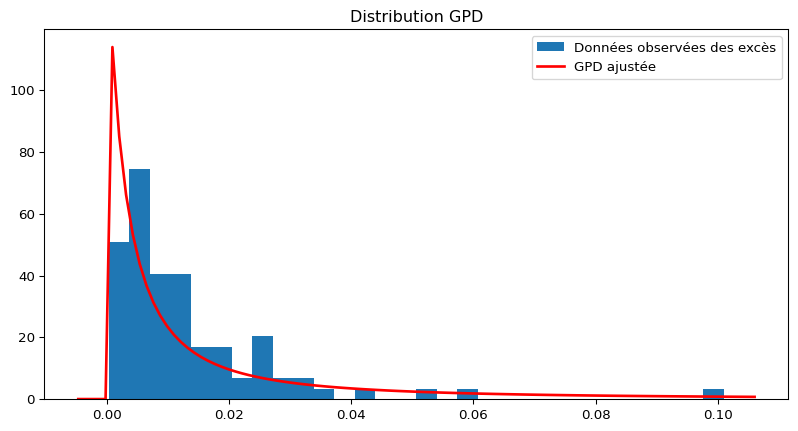

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(excess_values, bins=30, density=True, label='Donn√©es observ√©es des exc√®s')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Densit√© GPD ajust√©e
p_gpd = genpareto.pdf(x, *params_gpd)
plt.plot(x, p_gpd, 'r', linewidth=2, label='GPD ajust√©e')

title = "Distribution GPD"
plt.title(title)
plt.legend()
plt.show()

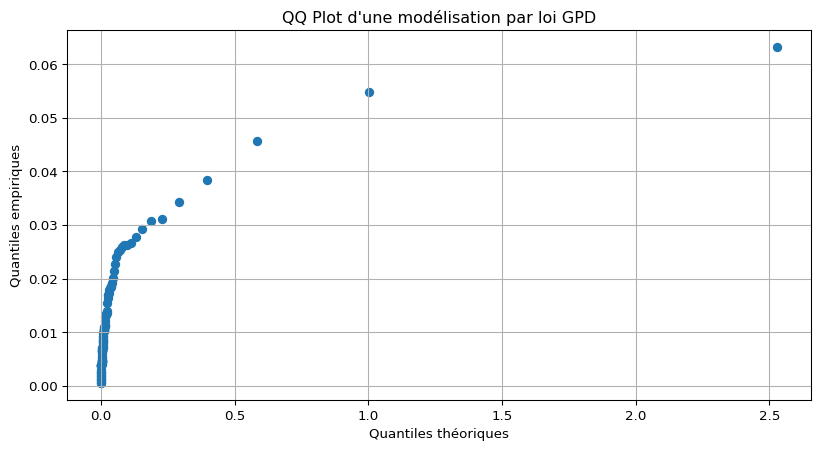

In [18]:
niveaux_quantiles = np.arange(0.01, 1, 0.01)
quantiles_empiriques_POT = np.quantile(excess_values, niveaux_quantiles)
quantiles_theoriques_GDP = genpareto.ppf(niveaux_quantiles, *params_gpd)

plt.figure(figsize=(10, 5))

plt.scatter(quantiles_theoriques_GDP, quantiles_empiriques_POT)
plt.title("QQ Plot d'une mod√©lisation par loi GPD")
plt.xlabel('Quantiles th√©oriques')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

### I.2.3. Calcul de la VaR POT par POT

La Value-at-Risk sur un horizon 1 jour et pour un niveau de confiance
${\alpha}$ est alors obtenue par la formule :

$$
\text{VaR}_h(\alpha) = \hat{H}_{(\hat{\sigma}, \hat{\xi}) }(\alpha_{\text{POT}})^{-1} + u,
$$

o√π $\hat{H}(\hat{\sigma}, \hat{\xi})$ est la fonction de r√©partition de
la GPD($\hat{\sigma},\hat{\xi}$) estim√©e, $\alpha_{\text{POT}}$ est le
quantile ajust√©, n√©cessaire pour adapter le calcul de la VaR dans le
cadre de la distribution GPD.

Comme on ne se concentre que sur l‚Äô√©chantillon des exc√®s dans cette
mod√©lisation, l‚Äôestimation de la VaR √† partir de la GPD ne doit pas se
faire au niveau $\alpha$, mais √† un niveau ajust√© $\alpha_{\text{POT}}$
d√©fini par la relation suivante :

$$
1 - \alpha_{\text{POT}} = \frac{n}{N_u} \times (1 - \alpha),
$$

o√π $n$ repr√©sente le nombre total d‚Äôobservations, $N_u$ correspond au
nombre d‚Äôexc√®s au-del√† du seuil $u$,

In [19]:
def POT_var(data,alpha,u,shape,loc,scale):
    """
    Calcul de la VaR gaussienne
    alpha : le niveau de confiance de la VaR
    s : le nombre de jours dans un bloc
    """
    n = len(data)
    excess_values = [value - u for value in data if value >= u]
    nu = len(excess_values)

    alpha_pot = 1-n*(1-alpha)/nu

    return genpareto.ppf(alpha_pot, shape, loc = loc, scale = scale) + u,alpha_pot

alpha = 0.99
var_POT_train,alpha_pot = POT_var(neg_data_train, alpha, u,*params_gpd)

print(f"La VaR TVE pour h=1j et alpha={alpha} est : {var_POT_train:.4%}")
print(f"La VaR TVE pour h=10j et alpha={alpha} est : {(10**alpha_pot)*var_POT_train:.4%}")

La VaR TVE pour h=1j et alpha=0.99 est : 4.3634%
La VaR TVE pour h=10j et alpha=0.99 est : 17.3572%